In [1]:
import expedia_apis

property_id = ["114116366"]    # Sentral Gaslamp Quarter San Diego
stay_len = 1
start_date = "2025-10-01"
end_date = "2026-04-07"
step = 7
occupancy = 2

checkin_dates = expedia_apis.generate_dates(start_date, end_date, step)
checkout_dates = [expedia_apis.add_days(date, stay_len) for date in checkin_dates]

dates = list(zip(checkin_dates, checkout_dates))


In [ ]:
# --- helpers ---
def best_rate_value(rate, occupancy_key):
    try:

        # print(rate["rooms"][0])
        return (
            rate["rooms"][0]["rates"][1]["occupancy_pricing"][occupancy_key]
            ["totals"]["inclusive"]["request_currency"]["value"]
        )
    
    except (KeyError, IndexError, TypeError):
        return None

from tqdm import tqdm

def fetch_rate(property_id, start_date, end_date, occupancy, rate_type):
    """Fetch the first rate from Expedia API for a given rate_type."""
    try:
        resp = expedia_apis.price_check(property_id, start_date, end_date, occupancy, 3, rate_type)
        if hasattr(resp, "raise_for_status"):
            resp.raise_for_status()

        data = resp.json()
        if isinstance(data, dict):
            for key in ("results", "offers", "data", "items"):
                if key in data:
                    data = data[key]
                    break

        if isinstance(data, list) and len(data) > 0:
            return best_rate_value(data[0], str(occupancy))
        return None
    except Exception:
        return None

priv_rates = []
mkt_rates = []
date_prices = []
for start_date, end_date in tqdm(dates, desc="Fetching rates", unit="date"):
    priv_rate = fetch_rate(property_id, start_date, end_date, occupancy, "priv_pkg")
    mkt_rate  = fetch_rate(property_id, start_date, end_date, occupancy, "mkt_prepay")
    priv_rate.append(priv_rate)

    date_prices.append(
        {
            "start_date": start_date,
            "end_date": end_date,
            "priv_rate": priv_rate,
            "mkt_rate": mkt_rate,
        }
    )

Fetching rates: 100%|██████████| 27/27 [00:17<00:00,  1.56date/s]


In [10]:
import pandas as pd

df = pd.DataFrame(date_prices)
df.to_excel("date_rates.xlsx")
df

,start_date,end_date,priv_rate,mkt_rate
0,2025-10-01,2025-10-02,None,None
1,2025-10-08,2025-10-09,None,None
2,2025-10-15,2025-10-16,None,None
3,2025-10-22,2025-10-23,None,None
4,2025-10-29,2025-10-30,None,None
5,2025-11-05,2025-11-06,None,None
6,2025-11-12,2025-11-13,None,None
7,2025-11-19,2025-11-20,None,None
8,2025-11-26,2025-11-27,None,None
9,2025-12-03,2025-12-04,None,None


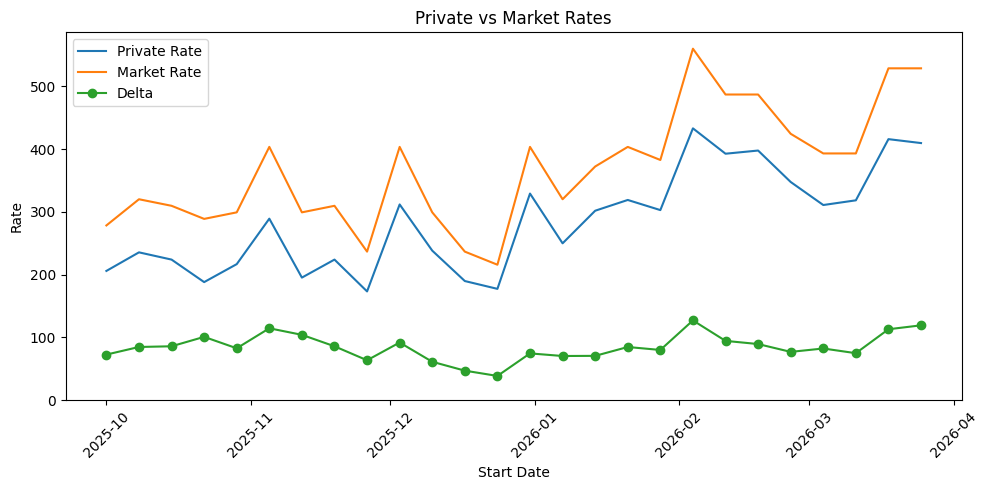

In [65]:
import math
from datetime import datetime
import matplotlib.pyplot as plt

def _to_float_or_nan(x):
    try:
        return float(x)
    except (TypeError, ValueError):
        return float('nan')

# Sort by date to keep the line chronological (optional but nice)
date_prices_sorted = sorted(
    date_prices,
    key=lambda d: datetime.strptime(d["start_date"], "%Y-%m-%d")
)

dates_plot = [datetime.strptime(d["start_date"], "%Y-%m-%d") for d in date_prices_sorted]
priv_rates = [_to_float_or_nan(d["priv_rate"]) for d in date_prices_sorted]
mkt_rates  = [_to_float_or_nan(d["mkt_rate"])  for d in date_prices_sorted]
delta = [
    (m - p) if math.isfinite(p) and math.isfinite(m) else float('nan')
    for p, m in zip(priv_rates, mkt_rates)
]

# If you want to keep only rows where at least one series is present:
# mask = [math.isfinite(p) or math.isfinite(m) for p, m in zip(priv_rates, mkt_rates)]
# dates_plot = [d for d, keep in zip(dates_plot, mask) if keep]
# priv_rates = [p for p, keep in zip(priv_rates, mask) if keep]
# mkt_rates  = [m for m, keep in zip(mkt_rates,  mask) if keep]

plt.figure(figsize=(10, 5))
plt.plot(dates_plot, priv_rates, label="Private Rate")
plt.plot(dates_plot, mkt_rates,  label="Market Rate")
plt.plot(dates_plot, delta,  label="Delta",  marker="o")

plt.xlabel("Start Date")
plt.ylabel("Rate")
plt.title("Private vs Market Rates")
plt.xticks(rotation=45)
plt.ylim(bottom=0)
plt.legend()
plt.tight_layout()
plt.show()